In [1]:
library(clusterProfiler)
library(dplyr)
library(msigdbr)
setwd("/data/TAK_981/")
library(org.Mm.eg.db)
library(ggplot2)
library(patchwork)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [2]:
ridgeplot.gseaResult <- function(x, showCategory=30, fill="p.adjust",
                                 core_enrichment = TRUE, label_format = 30,
                                 orderBy = "NES", decreasing = FALSE) {
    if (!is(x, "gseaResult"))
        stop("currently only support gseaResult")

    ## fill <- match.arg(fill, c("pvalue", "p.adjust", "qvalue"))
    if (fill == "qvalue") {
        fill <- "qvalues"
    }
    if (!fill %in% colnames(x@result)) {
        stop("'fill' variable not available ...")
    }

    ## geom_density_ridges <- get_fun_from_pkg('ggridges', 'geom_density_ridges')
    if (orderBy !=  'NES' && !orderBy %in% colnames(x@result)) {
        message('wrong orderBy parameter; set to default `orderBy = "NES"`')
        orderBy <- "NES"
    }
    if (inherits(showCategory, 'numeric')) {
        selected <- seq_len(showCategory)
    } else if (inherits(showCategory, "character")) {
        ii <- match(showCategory, x@result$Description)
        selected <- x@result[ii, "ID"]
        }
    if (core_enrichment) {
        gs2id <- geneInCategory(x)[selected]
    } 
    else {
    gs2id <- x@geneSets[x$ID[which(x$ID %in% selected)]]
    }

    if (x@readable) {
        id <- match(names(x@geneList), names(x@gene2Symbol))
        names(x@geneList) <- x@gene2Symbol[id]
    } 

    gs2val <- lapply(gs2id, function(id) {
        res <- x@geneList[id]
        res <- res[!is.na(res)]
    })

    nn <- names(gs2val)
    i <- match(nn, x$ID)
    nn <- x$Description[i]

    # j <- order(x$NES[i], decreasing=FALSE)
    j <- order(x@result[[orderBy]][i], decreasing = decreasing)
    len <- sapply(gs2val, length)
    gs2val.df <- data.frame(category = rep(nn, times=len),
                            color = rep(x[i, fill], times=len),
                            value = unlist(gs2val))

    colnames(gs2val.df)[2] <- fill
    gs2val.df$category <- factor(gs2val.df$category, levels=nn[j])
    label_func <- enrichplot:::default_labeller(label_format)
    if(is.function(label_format)) {
        label_func <- label_format
    }

    ggplot(gs2val.df, aes_string(x="value", y="category", fill=fill)) +
        ggridges::geom_density_ridges() +
        ## scale_x_reverse() +
        scale_fill_continuous(low="red", high="blue", name = fill,
            guide=guide_colorbar(reverse=TRUE)) +
        scale_y_discrete(labels = label_func) +
        ## scale_fill_gradientn(name = fill, colors=sig_palette, guide=guide_colorbar(reverse=TRUE)) +
        ## geom_vline(xintercept=0, color='firebrick', linetype='dashed') +
        xlab(NULL) + ylab(NULL) +  DOSE::theme_dose()
}

In [28]:
barplot_group <- function (height, x = "Count", color = "p.adjust", showCategory = 8, 
    font.size = 12, title = "", label_format = 30, col="#E06663", ...) 
{
    object <- height
    colorBy <- match.arg(color, c("pvalue", "p.adjust", "qvalue"))
    if (x == "geneRatio" || x == "GeneRatio") {
        x <- "GeneRatio"
    }
    else if (x == "count" || x == "Count") {
        x <- "Count"
    }
    df <- fortify(object, showCategory = showCategory, by = x, 
        ...)
    if (colorBy %in% colnames(df)) {
        p <- ggplot(df, aes_string(x = x, y = "Cluster")) + DOSE:::theme_dose(font.size)
    }
    else {
        p <- ggplot(df, aes_string(x = x, y = "Description", 
            fill = "Description")) + DOSE:::theme_dose(font.size) + 
            theme(legend.position = "none")
    }
    label_func <- enrichplot:::default_labeller(label_format)
    if (is.function(label_format)) {
        label_func <- label_format
    }
    p + geom_col(fill=col) + scale_y_discrete(labels = label_func) + 
        ggtitle(title) + ylab(NULL)
}

In [4]:
m_df_hallmark <- msigdbr(species = "Mus musculus", category="H") %>% dplyr::select(gs_name, gene_symbol)
#m_df_go <- msigdbr(species = "Mus musculus", category="C5") %>% dplyr::select(gs_name, gene_symbol)
m_df_curated <- msigdbr(species = "Mus musculus", category="C2", subcategory = "CP") %>% dplyr::select(gs_name, gene_symbol)

In [6]:
files <- sub(".csv$","",  list.files("csv/de/memento/", full.names=FALSE))

In [7]:
hallmark <- lapply(files, FUN=function(n){
    df <- read.csv(paste0("csv/de/memento/", n, ".csv")) %>% filter(tx=="treat")
    original_gene_list <- df$de_coef
    names(original_gene_list) <- df$gene
    gene_list<-na.omit(original_gene_list)
    gene_list = sort(gene_list, decreasing = TRUE)
    gse_h<-GSEA(gene_list,
                TERM2GENE=m_df_hallmark,
                minGSSize=10, eps=0, pvalueCutoff = 1, nPermSimple = 10000)
    write.csv(gse_h[], paste0("csv/gsea/", n, "_hallmark.csv"))
    ridgeplot(gse_h, showCategory = 10)
    ggsave(paste0("figs/gsea/", n, "_hallmark.png"), height=12, width=8)
    gse_h
})
currated <- lapply(files, FUN=function(n){
    df <- read.csv(paste0("csv/de/memento/", n, ".csv")) %>% filter(tx=="treat")
    original_gene_list <- df$de_coef
    names(original_gene_list) <- df$gene
    gene_list<-na.omit(original_gene_list)
    gene_list = sort(gene_list, decreasing = TRUE)
    gse_curated<-GSEA(gene_list,
            TERM2GENE=m_df_curated,
            minGSSize=10, eps=0, nPermSimple = 10000, pvalueCutoff = 1)
    write.csv(gse_curated[], paste0("csv/gsea/", n, "_currated.csv"))
    ridgeplot(gse_curated, showCategory = 10)
    ggsave(paste0("figs/gsea/", n, "_gse_curated.png"), height=12, width=8)
    gse_curated
    })

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 4 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 100000)”
leading edge analysis...

done...

Picking joint bandwidth of 0.0686

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are se

In [8]:
names(currated) <- files
names(hallmark) <- files

In [9]:
names(hallmark)

[1] "Epithelial_cd40vcombo"  "Epithelial_ctrlvcd40"   "Epithelial_ctrlvcombo" 
 [4] "Epithelial_ctrlvtak"    "Epithelial_takvcd40"    "Epithelial_takvcombo"  
 [7] "Macrophages_cd40vcombo" "Macrophages_ctrlvcd40"  "Macrophages_ctrlvcombo"
[10] "Macrophages_ctrlvtak"   "Macrophages_takvcd40"   "Macrophages_takvcombo" 
[13] "T-Cells_cd40vcombo"     "T-Cells_ctrlvcd40"      "T-Cells_ctrlvcombo"    
[16] "T-Cells_ctrlvtak"       "T-Cells_takvcd40"       "T-Cells_takvcombo"

In [11]:
for (n in c("Epithelial", "T-Cells", "Macrophages")){
    x<-ridgeplot(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES")
    y<-ridgeplot(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES")
    z<-ridgeplot(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES")
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_NES.png"))
    x<-ridgeplot(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE")
    y<-ridgeplot(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE")
    z<-ridgeplot(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE")
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_padj.png"))
    x<-ridgeplot.gseaResult(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES", core_enrichment = F)
    y<-ridgeplot.gseaResult(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES", core_enrichment = F)
    z<-ridgeplot.gseaResult(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES", core_enrichment = F)
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_NES_noncore.png"))
    x<-ridgeplot.gseaResult(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", core_enrichment = F)
    y<-ridgeplot.gseaResult(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", core_enrichment = F)
    z<-ridgeplot.gseaResult(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", core_enrichment = F)
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_padj_noncore.png"))
    
}

Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.0895

Picking joint bandwidth of 0.112

Picking joint bandwidth of 0.0761

Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.0895

Picking joint bandwidth of 0.112

Picking joint bandwidth of 0.0761

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.112

Picking joint bandwidth of 0.111

Picking joint bandwidth of 0.101

Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.112

Picking joint bandwidth of 0.111

Picking joint bandwidth of 0.101

Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.115

Picking joint bandwidth of 0.118

Picking joint bandwidth of 0.0756

Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.115

Picking joint bandwidth of 0.118

Picking joint bandwidth of 0.0756

Saving 6.67 x 6.67 in image
Pi

In [30]:
for (n in c("Epithelial", "T-Cells", "Macrophages")){
    res <- c(hallmark[[paste0(n, "_ctrlvcombo")]], hallmark[[paste0(n, "_takvcombo")]], hallmark[[paste0(n, "_cd40vcombo")]])
    names(res) <- c("ctrl_v_combo", "tak_v_combo", "cd40_v_combo")
    merged <- merge_result(res)
    test<-barplot_group(merged, showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", x="NES", title=paste0(n, " Hallmark Interferon Alpha Response GSEA Enrichment"))
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_barplot.png"))
    test<-barplot_group(merged, showCategory="HALLMARK_INTERFERON_GAMMA_RESPONSE", x="NES", title=paste0(n, " Hallmark Interferon Gamma Response GSEA Enrichment"), col="#00BFC4")
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infg_pathways_barplot.png"))

}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


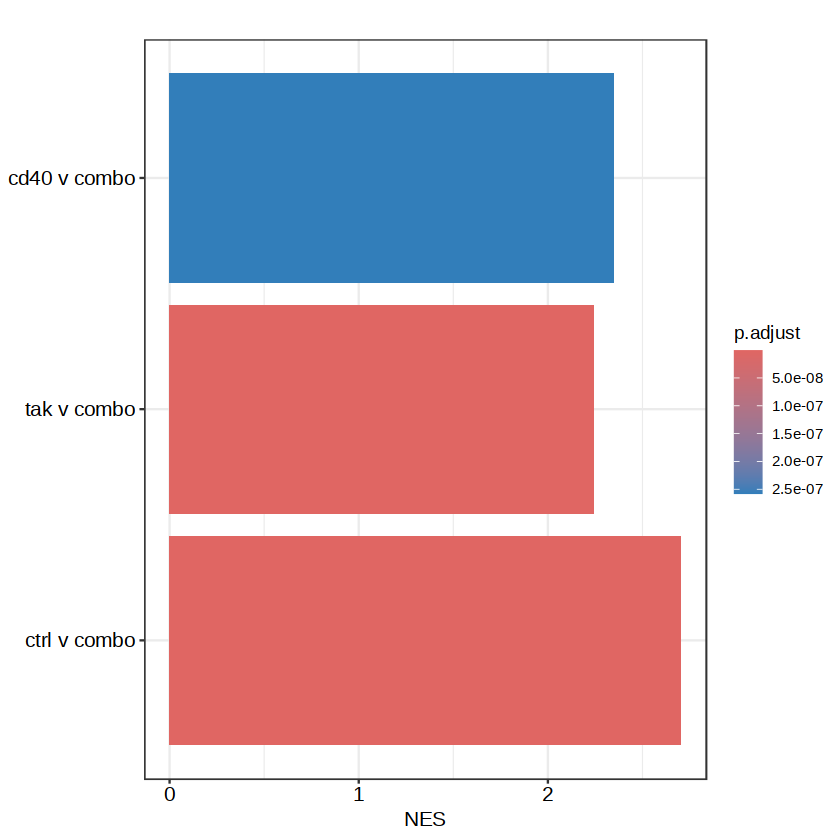

In [25]:
barplot_group(merged, showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", x="NES")

In [ ]:
for (n in c("Epithelial", "T-Cells", "Macrophages")){
    x<-ridgeplot(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES")
    y<-ridgeplot(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES")
    z<-ridgeplot(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES")
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_NES.png"))
    x<-ridgeplot(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE")
    y<-ridgeplot(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE")
    z<-ridgeplot(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE")
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_padj.png"))
    x<-ridgeplot.gseaResult(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES", core_enrichment = F)
    y<-ridgeplot.gseaResult(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES", core_enrichment = F)
    z<-ridgeplot.gseaResult(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", fill="NES", core_enrichment = F)
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_NES_noncore.png"))
    x<-ridgeplot.gseaResult(hallmark[[paste0(n, "_ctrlvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", core_enrichment = F)
    y<-ridgeplot.gseaResult(hallmark[[paste0(n, "_takvcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", core_enrichment = F)
    z<-ridgeplot.gseaResult(hallmark[[paste0(n, "_cd40vcombo")]], showCategory="HALLMARK_INTERFERON_ALPHA_RESPONSE", core_enrichment = F)
    x$data$category <- "IFN_CTRL_V_COMBO"
    y$data$category <- "IFN_TAK_V_COMBO"
    z$data$category <- "IFN_CD40_V_COMBO"
    x/y/z
    ggsave(paste0("figs/gsea/inf_pathways/", n, "_infa_pathways_padj_noncore.png"))
    
}

In [4]:
files <- sub(".csv$","",  list.files("csv/de/memento_nosamp/", full.names=FALSE))

In [5]:
hallmark <- lapply(files, FUN=function(n){
    df <- read.csv(paste0("csv/de/memento_nosamp/", n, ".csv")) %>% filter(tx=="treat")
    original_gene_list <- df$de_coef
    names(original_gene_list) <- df$gene
    gene_list<-na.omit(original_gene_list)
    gene_list = sort(gene_list, decreasing = TRUE)
    gse_h<-GSEA(gene_list,
                TERM2GENE=m_df_hallmark,
                minGSSize=10, eps=0, pvalueCutoff = 1, nPermSimple = 10000)
    write.csv(gse_h[], paste0("csv/gsea/memento_nosamp_gsea/", n, "_hallmark.csv"))
    ridgeplot(gse_h, showCategory = 10)
    ggsave(paste0("figs/gsea/gsea_mementonosamp/", n, "_hallmark.png"), height=12, width=8)
    gse_h
})
currated <- lapply(files, FUN=function(n){
    df <- read.csv(paste0("csv/de/memento_nosamp/", n, ".csv")) %>% filter(tx=="treat")
    original_gene_list <- df$de_coef
    names(original_gene_list) <- df$gene
    gene_list<-na.omit(original_gene_list)
    gene_list = sort(gene_list, decreasing = TRUE)
    gse_curated<-GSEA(gene_list,
            TERM2GENE=m_df_curated,
            minGSSize=10, eps=0, nPermSimple = 10000, pvalueCutoff = 1)
    write.csv(gse_curated[], paste0("csv/gsea/memento_nosamp_gsea/", n, "_currated.csv"))
    ridgeplot(gse_curated, showCategory = 10)
    ggsave(paste0("figs/gsea/gsea_mementonosamp/", n, "_gse_curated.png"), height=12, width=8)
    gse_curated
    })

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 3 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 100000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
leading edge analysis...

done...

Picking joint bandwidth of 0.0624

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = min